In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)


In [1]:
import tensorflow as tf
import pandas as pd
from helper_functions.get_epsilon_subset import get_epsilon_subset
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="darkgrid")

# Get DATA (Thanks to Abasse)

In [2]:
data = get_epsilon_subset()
data.head()

,YEAR,W_1_1,W_1_2,W_1_3,W_1_4,W_1_5,W_1_6,W_1_7,W_1_8,W_1_9,...,W_4_13,W_4_14,W_4_15,W_4_16,W_4_17,W_4_18,YIELD_1,YIELD_2,YIELD_3,YIELD_4
0,1,21.430837,22.228488,24.205256,29.859199,30.434175,26.467017,27.300290,22.509277,16.388211,...,0.319974,1.612761,3.304209,0.060819,1.540583,3.214933,5.54,6.61,10.39,5.77
1,2,18.841767,25.165941,24.169267,28.742330,27.342035,27.945379,25.710641,22.343698,19.797961,...,2.165768,1.791010,3.012968,4.316012,2.021236,0.814444,4.39,6.86,8.49,8.65
2,10,23.067487,21.989987,26.730305,27.207224,28.277049,26.121537,30.583426,22.363784,15.826520,...,1.402261,2.402111,2.140366,1.821273,1.763787,4.698325,4.07,6.04,6.12,6.34
3,28,24.441997,24.273763,23.400111,27.344886,25.011067,28.047828,25.841452,20.996116,16.747943,...,0.520928,1.781335,2.064324,2.425123,3.876324,1.230727,4.77,6.08,10.60,3.93
4,33,21.562630,22.283709,25.263382,25.713687,28.258033,28.984649,26.601343,23.831066,17.453389,...,0.466796,0.665607,2.231320,2.971977,1.737167,3.273389,4.40,3.51,8.60,5.58


## Data Distribution

Seems to be sort of Gaussians

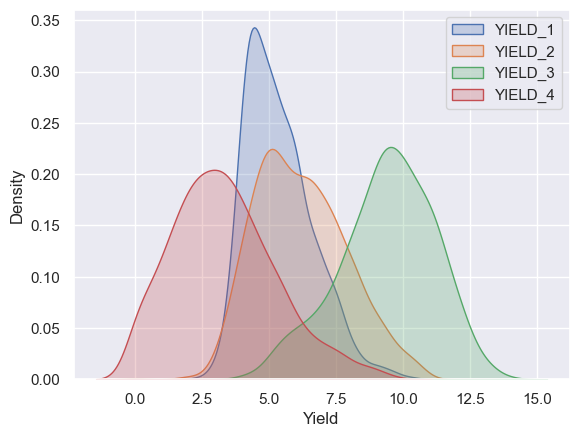

In [3]:
sns.kdeplot(data, x="YIELD_1", fill=True, label="YIELD_1")
sns.kdeplot(data, x="YIELD_2", fill=True, label="YIELD_2")
sns.kdeplot(data, x="YIELD_3", fill=True, label="YIELD_3")
sns.kdeplot(data, x="YIELD_4", fill=True, label="YIELD_4")
plt.xlabel("Yield")
plt.legend()
plt.show()

## Data Loader

In [4]:
batch_size = 128
data_tensor = tf.convert_to_tensor(data[[f"YIELD_{i}" for i in range(1, 5)]], dtype=tf.float64)
print(data_tensor.shape)
mean, std = tf.math.reduce_mean(data_tensor, axis=0, keepdims=True), tf.math.reduce_std(data_tensor, axis=0, keepdims=True)
print(mean.shape, std.shape)

(1000, 4)
(1, 4) (1, 4)


In [5]:
def normalize(data, mean=mean, std=std):
    return (data - mean) / std

In [6]:

dataloader = tf.data.Dataset.from_tensor_slices(data_tensor)
dataloader = dataloader.cache()
dataloader = dataloader.batch(batch_size)
dataloader = dataloader.shuffle(60000)
dataloader = dataloader.prefetch(32)
dataloader = dataloader.map(normalize)
Z_DIM = 25

dataloader.as_numpy_iterator().next().shape

(128, 4)

# Building Model

In [7]:
# Define the generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(Z_DIM,)))
    model.add(layers.Dense(128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(4, use_bias=False, activation='tanh'))

    return model

# Define the discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=False, input_shape=(4,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [8]:
generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3200      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8192      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                

In [9]:
generator.predict(tf.random.normal([1, Z_DIM])).shape

1/1 [==============================] - 0s 126ms/step


(1, 4)

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                256       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8192      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [11]:
discriminator.predict(generator.predict(tf.random.normal([5, Z_DIM]))).shape

1/1 [==============================] - 0s 71ms/step


(5, 1)

## GAN model

In [12]:
noise_std = 0.05
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super(GAN, self).__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, *args, **kwargs):
        super(GAN, self).compile(*args, **kwargs)
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, batch):
        # print(tf.shape(batch))
        real_yields = batch
        fake_yields = self.generator(tf.random.normal([batch_size,  Z_DIM]), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake yields to the discriminator
            yhat_real = self.discriminator(real_yields, training=True)
            yhat_fake = self.discriminator(fake_yields, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            # create labels for the discriminator
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # add some noise to the labels
            y_realfake += noise_std * tf.random.uniform(tf.shape(y_realfake))

            # calculate the loss for the discriminator
            d_loss = self.d_loss_fn(y_realfake, yhat_realfake)

        # calculate the gradients for the discriminator
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # generate fake yields
            fake_yields = self.generator(tf.random.normal([batch_size, Z_DIM, 1]), training=True)

            # predict the labels using the discriminator
            yhat_fake = self.discriminator(fake_yields, training=False)

            # calculate the loss for the generator
            g_loss = self.g_loss_fn(tf.zeros_like(yhat_fake), yhat_fake)

        # calculate the gradients for generator
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

    def call(self, inputs):
        return self.discriminator(inputs)

# Training

In [13]:
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-3),
    d_optimizer=tf.keras.optimizers.Adam(1e-5),
    g_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy()
)

## Fitting

In [14]:
hist = gan.fit(dataloader, epochs=30)

Epoch 1/30


8/8 [==============================] - 2s 6ms/step - d_loss: 0.7481 - g_loss: 0.7069
Epoch 2/30
8/8 [==============================] - 0s 6ms/step - d_loss: 0.7553 - g_loss: 0.6764
Epoch 3/30
8/8 [==============================] - 0s 6ms/step - d_loss: 0.7551 - g_loss: 0.6620
Epoch 4/30
8/8 [==============================] - 0s 5ms/step - d_loss: 0.7648 - g_loss: 0.6543
Epoch 5/30
8/8 [==============================] - 0s 6ms/step - d_loss: 0.7646 - g_loss: 0.6487
Epoch 6/30
8/8 [==============================] - 0s 4ms/step - d_loss: 0.7651 - g_loss: 0.6465
Epoch 7/30
8/8 [==============================] - 0s 5ms/step - d_loss: 0.7681 - g_loss: 0.6463
Epoch 8/30
8/8 [==============================] - 0s 5ms/step - d_loss: 0.7667 - g_loss: 0.6470
Epoch 9/30
8/8 [==============================] - 0s 4ms/step - d_loss: 0.7648 - g_loss: 0.6488
Epoch 10/30
8/8 [==============================] - 0s 5ms/step - d_loss: 0.7648 - g_loss: 0.6516
Epoch 11/30
8/8 [==============================] -

## Results

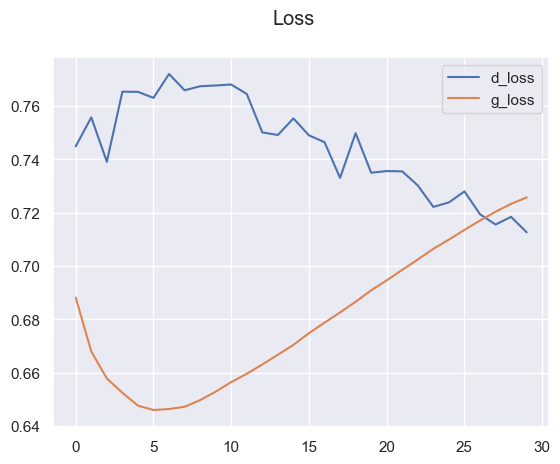

In [15]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Generation

32/32 [==============================] - 0s 1ms/step


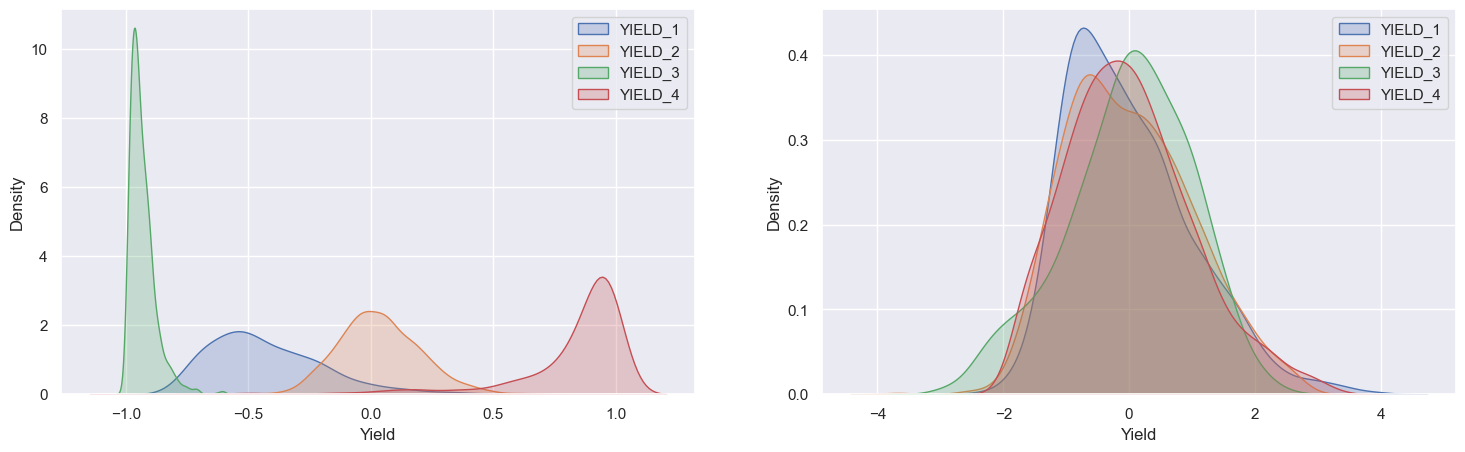

In [17]:
Z_test = tf.random.normal([1000, Z_DIM])
yhat = generator.predict(Z_test)
plt.figure(figsize=(18, 5))
plt.subplot(121)
sns.kdeplot(yhat[:, 0], fill=True, label="YIELD_1")
sns.kdeplot(yhat[:, 1], fill=True, label="YIELD_2")
sns.kdeplot(yhat[:, 2], fill=True, label="YIELD_3")
sns.kdeplot(yhat[:, 3], fill=True, label="YIELD_4")
plt.xlabel("Yield")
plt.legend()
plt.subplot(122)
normalized_data = (data_tensor - mean) / std
sns.kdeplot(normalized_data[:, 0], fill=True, label="YIELD_1")
sns.kdeplot(normalized_data[:, 1], fill=True, label="YIELD_2")
sns.kdeplot(normalized_data[:, 2], fill=True, label="YIELD_3")
sns.kdeplot(normalized_data[:, 3], fill=True, label="YIELD_4")
plt.xlabel("Yield")
plt.legend()
plt.show()